# Modify Battery Storage Parameters Example
---
In this example, we will show how to modify the battery storage parameters in the hybrid plant simulation. The major change is from using the default dispatch which is a profit maximization objective function to a load following objective function. The load follow objective will minimize system operating costs while load following.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [25]:
import numpy as np

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

import pandas as pd

### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [26]:
ev_load = pd.read_csv("../ev/data/ev_demand_22.csv", header=None)

In [27]:
ev_load.iloc[:, 0].values

array([0.        , 0.        , 0.        , ..., 0.00476309, 0.00583339,
       0.00458514])

In [28]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

baseload_limit_kw = float(30 * 1000)
baseload_percent = 95.0
DEFAULT_LOAD = baseload_limit_kw*np.ones((8760))/1000

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=ev_load.iloc[:, 0].values,
        solar=True,
        wind=True,
        wave=False
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [29]:
hopp_config = load_yaml("./inputs/ev-load-following-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [30]:
hi = HoppInterface(hopp_config)

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 20 years).

In [31]:
hi.simulate(project_life=20)

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [32]:
hybrid_plant = hi.system

# print("Output after losses over gross output:",
      # hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

print("Total Revenues:")
print(revs)

Annual Energies:
{"pv": 1042978.6244815168, "wind": 1637452.263344609, "battery": -858.036323536469, "hybrid": 171099.58127259518}
Net Present Values:
{"pv": -50415.63510742894, "wind": 6112.550491147907, "battery": -108597.64349313245, "hybrid": -1131790.8369315919}
Total Revenues:
{"pv": [0.0, 40419.14937527, 40823.34086902269, 41231.57427771292, 41643.89002049006, 42060.32892069495, 42480.932209901905, 42905.741532000924, 43334.79894732093, 43768.14693679414, 44205.82840616208, 44647.886690223706, 45094.365557125944, 45545.3092126972, 46000.76230482417, 46460.76992787242, 46925.37762715114, 47394.63140342266, 47868.57771745687, 48347.26349463145, 48830.73612957776], "wind": [0.0, 64398.09170792205, 65042.072625001274, 65692.49335125128, 66349.4182847638, 67012.91246761143, 67683.04159228755, 68359.87200821043, 69043.47072829252, 69733.90543557546, 70431.24448993121, 71135.55693483053, 71846.91250417884, 72565.38162922062, 73291.03544551283, 74023.94579996796, 74764.18525796763, 7551

### Visualize Simulation Results (Optional)
Optionally, you can visualize the simulation results using plots. Several functions are provided for plotting battery output, generation profiles, and dispatch errors.

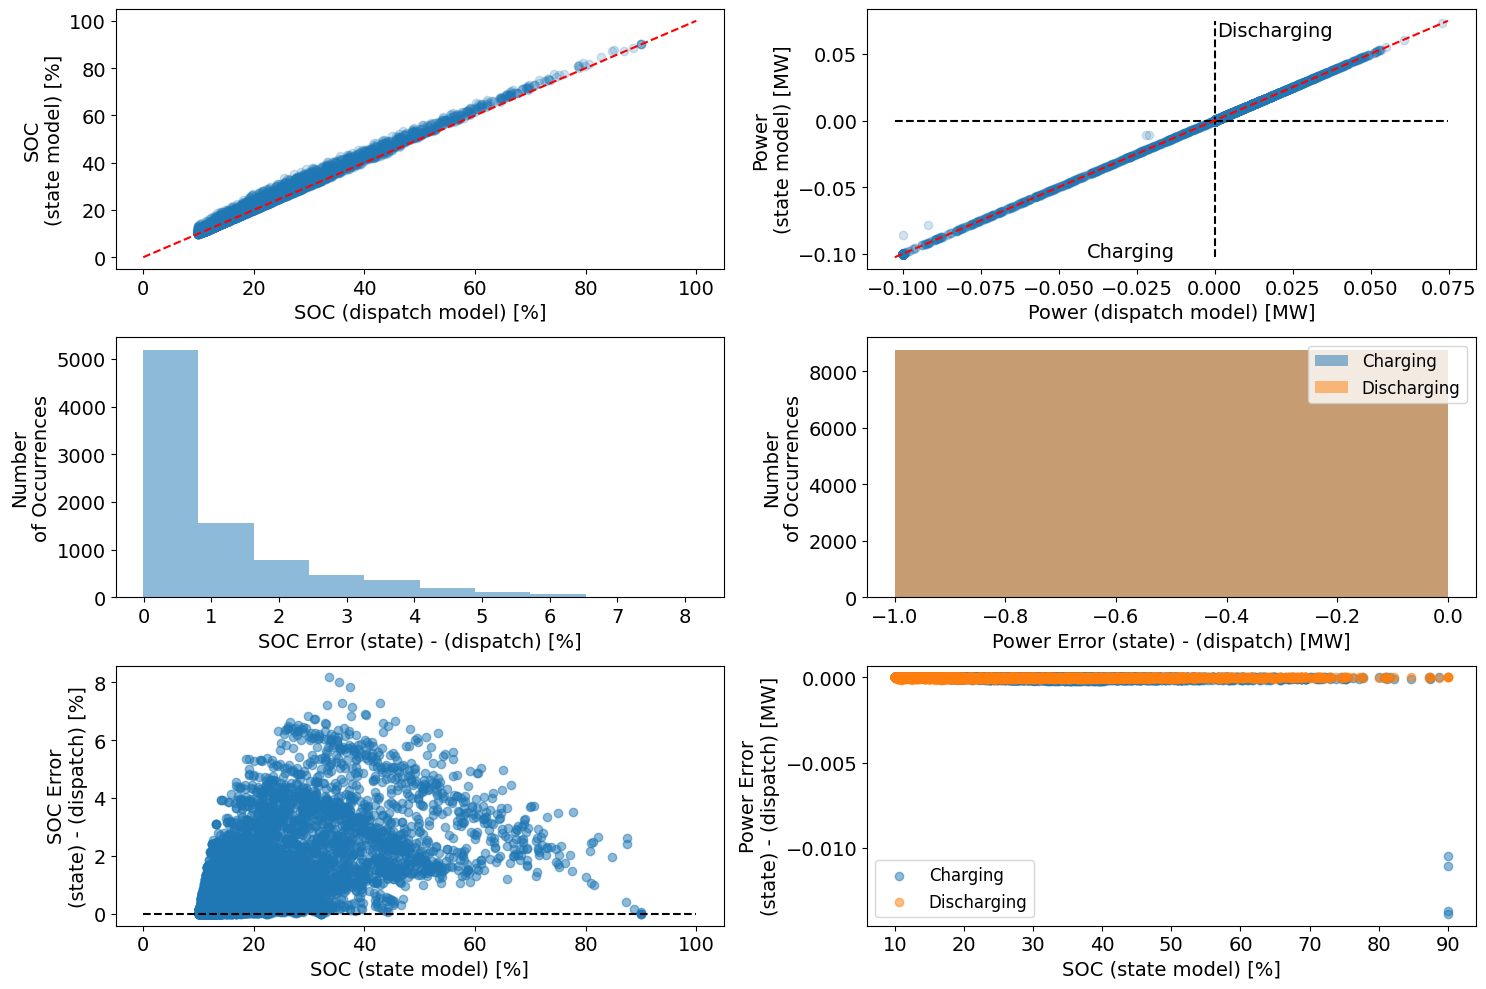

In [33]:
plot_battery_dispatch_error(hybrid_plant)

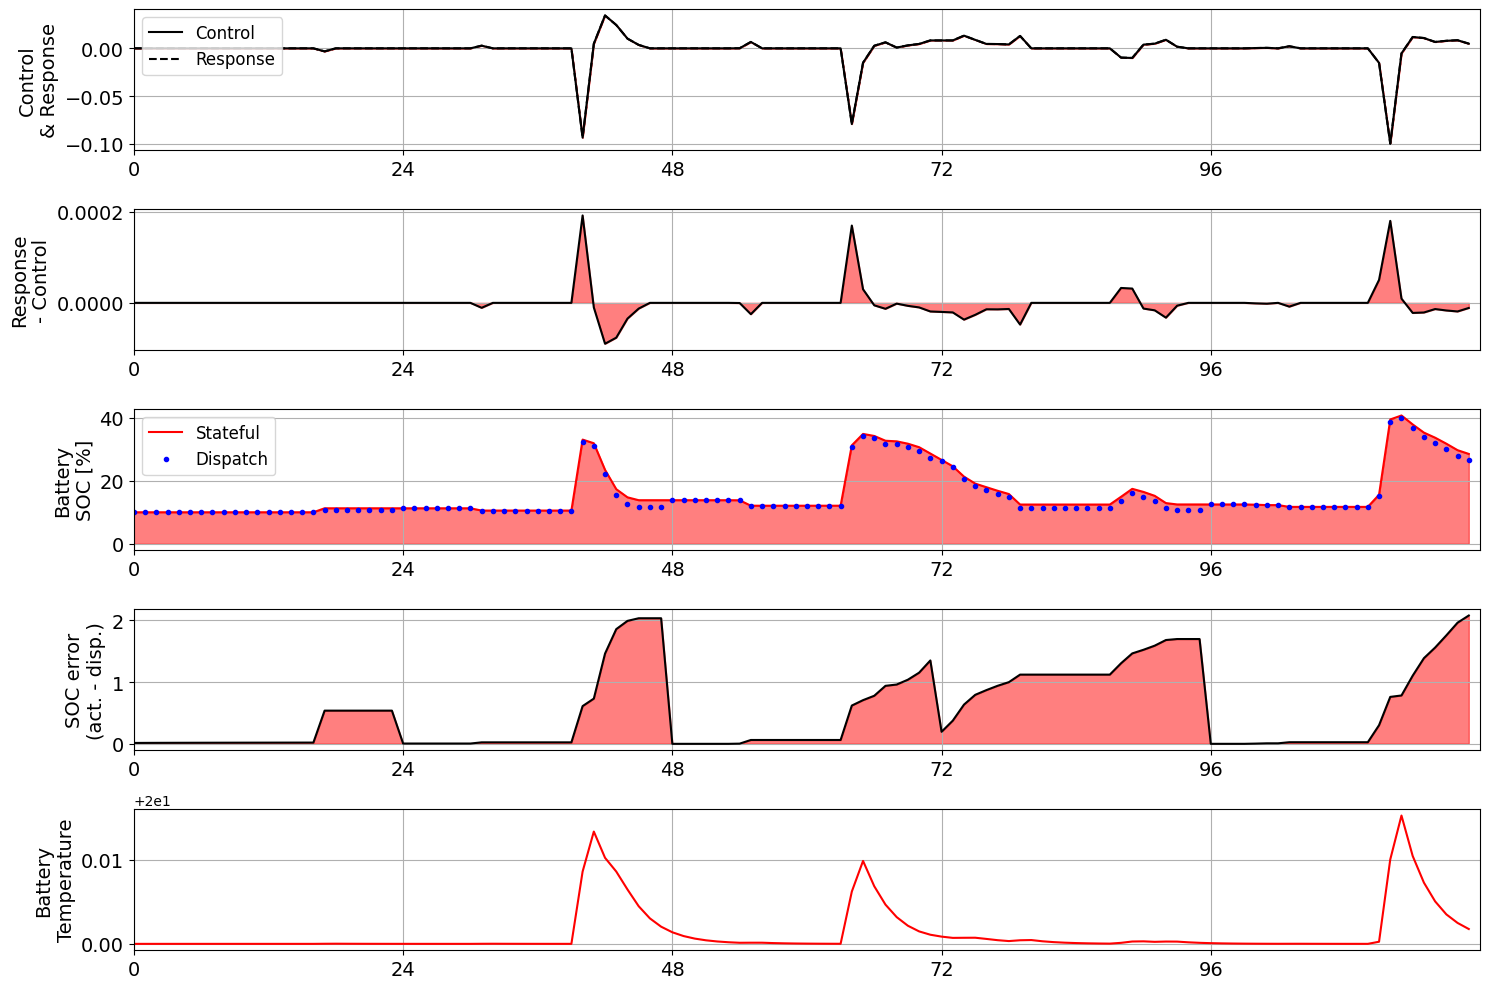

In [34]:
plot_battery_output(hybrid_plant)

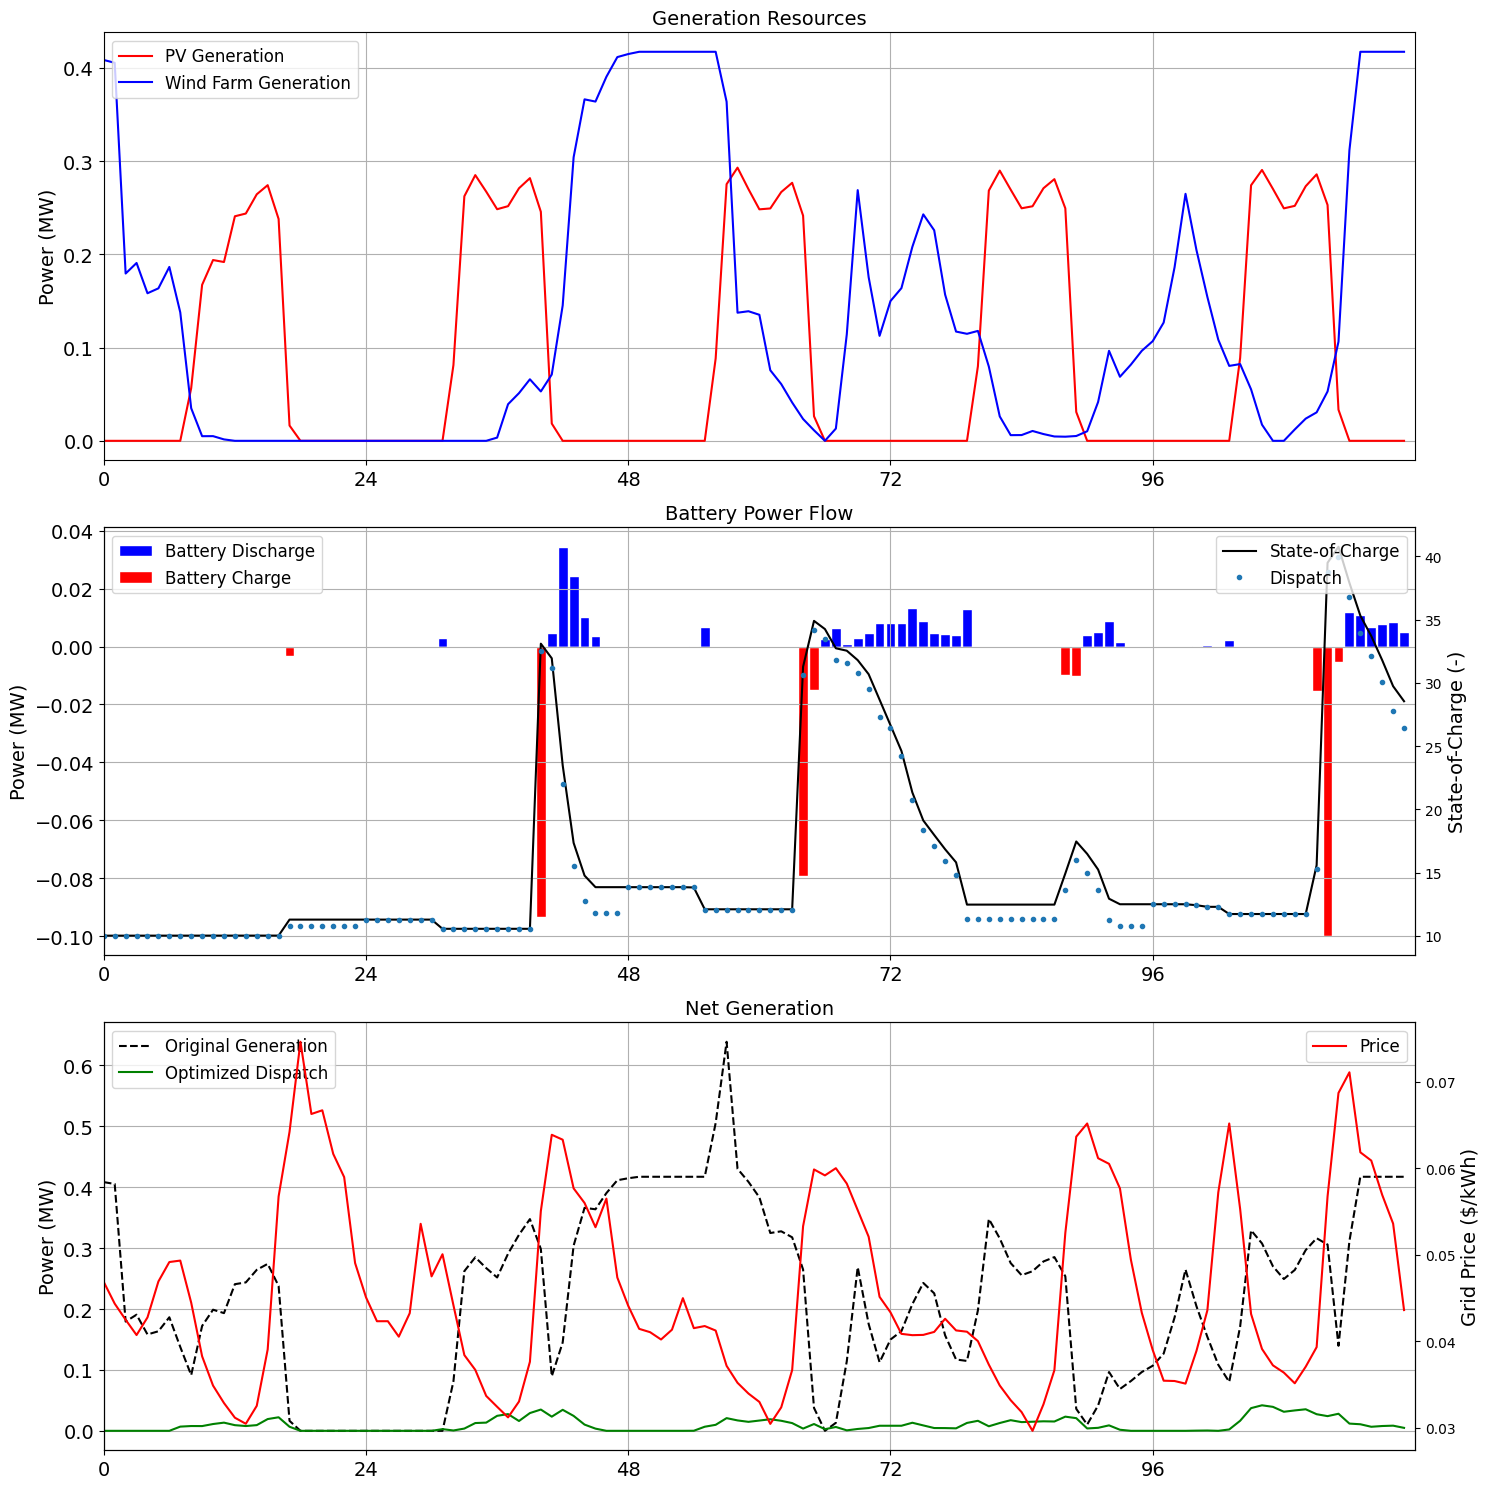

In [35]:
plot_generation_profile(hybrid_plant)

In [36]:
periods = 24*7
dates = pd.date_range(start="2022-01-01", periods=periods, freq="H")

In [37]:
hybrid_plant.grid.energy_purchases

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

In [38]:
hybrid_plant.grid.missed_load.sum()

225.04050489580183

In [39]:
hybrid_plant.lcoe_real.hybrid/100

0.6318643394691646

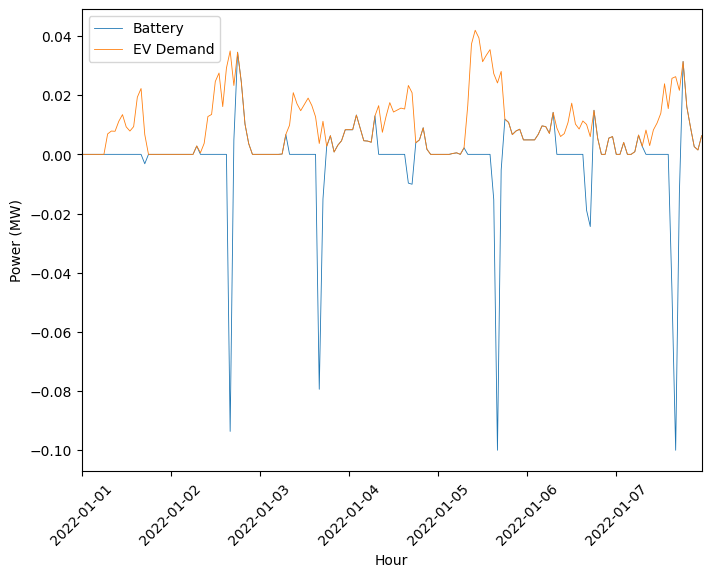

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(8760)
y = hybrid_plant.battery.outputs.dispatch_P

ax.plot(dates, y[:periods], linewidth=.6, label="Battery")
ax.plot(dates, ev_load[:periods], linewidth=.6, label="EV Demand")

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
        
ax.set_xlabel("Hour")
ax.set_ylabel("Power (MW)")
ax.set_xmargin(0)

ax.legend()